Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

      Change       0.97      0.99      0.98      1917
    Incident       0.82      0.80      0.81      1917
     Problem       0.80      0.82      0.81      1918
     Request       0.98      0.96      0.97      1917

    accuracy                           0.89      7669
   macro avg       0.89      0.89      0.89      7669
weighted avg       0.89      0.89      0.89      7669



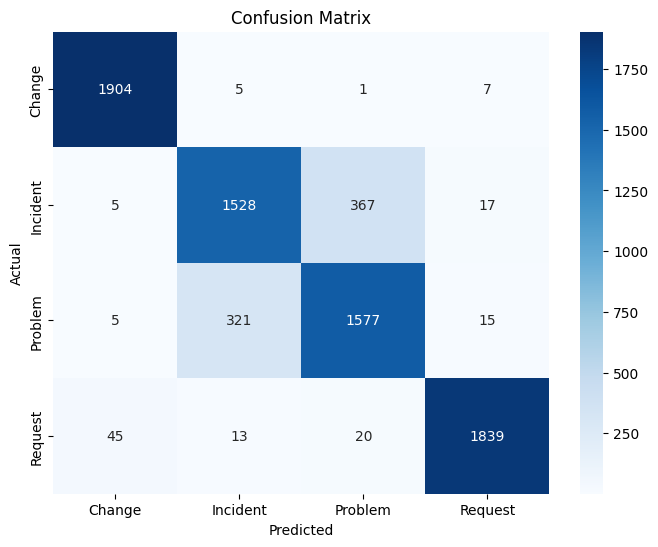


--- DEMO ---
Predicted Category: Request
Masked Text: Subject: Customer Support Inquiry

Seeking information on digital strategies that can aid in brand growth and details on the available services. Looking forward to learning more to help our business grow My name is [full_name_000].. Thank you, and I look forward to hearing from you soon. You can reach me at [email_000].
Restored Email: Subject: Customer Support Inquiry

Seeking information on digital strategies that can aid in brand growth and details on the available services. Looking forward to learning more to help our business grow My name is Elena Ivanova.. Thank you, and I look forward to hearing from you soon. You can reach me at fatima.farsi@help.com.


In [ ]:
import re
import pandas as pd
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ast


ner = pipeline('ner', model='Davlan/xlm-roberta-base-ner-hrl', grouped_entities=True)

# Regex patterns for PII detection
EMAIL_REGEX = r'\b[\w\.-]+@[\w\.-]+\.\w{2,}\b'
AADHAAR_REGEX = r'\b\d{4}\s?\d{4}\s?\d{4}\b'
CARD_REGEX = r'\b(?:\d[ -]*?){13,19}\b'
CVV_REGEX = r'(?i)\b(?:cvv[:\s\-]*)?(\d{3,4})\b'
EXPIRY_REGEX = r'\b(0[1-9]|1[0-2])[\/\-]\d{2,4}\b'
PHONE_REGEX = r'\+?\d[\d\s\-]{7,14}\d'
DOB_REGEX = r'\b\d{1,2}[\/\-\.\s]\d{1,2}[\/\-\.\s]\d{2,4}\b'

# Maping NER entity labels to token names
NER_TO_TOKEN = {
    'PER': 'full_name',
    'EMAIL': 'email',
    'DATE': 'dob'
}

def mask_pii(text, mapping=None, counter=None):
    if mapping is None:
        mapping = {}
    if counter is None:
        counter = {
            'full_name': 0,
            'email': 0,
            'phone_number': 0,
            'dob': 0,
            'aadhar_num': 0,
            'credit_debit_no': 0,
            'cvv_no': 0,
            'expiry_no': 0
        }

    # Masking NER entities first
    entities = ner(text)
    for ent in entities:
        label = ent['entity_group']
        if label in NER_TO_TOKEN:
            token_name = NER_TO_TOKEN[label]
            original = ent['word'].replace('##', '')
            token = f"[{token_name}_{counter[token_name]:03d}]"
            if original in text:
                text = text.replace(original, token, 1)
                mapping[token] = original
                counter[token_name] += 1

    # Masking with regex patterns
    regex_map = [
        (CARD_REGEX, 'credit_debit_no'),
        (AADHAAR_REGEX, 'aadhar_num'),
        (PHONE_REGEX, 'phone_number'),
        (CVV_REGEX, 'cvv_no'),
        (EXPIRY_REGEX, 'expiry_no'),
        (EMAIL_REGEX, 'email'),
        (DOB_REGEX, 'dob')
    ]

    for regex, token_name in regex_map:
        def replacer(match):
            original = match.group(0)
            token = f"[{token_name}_{counter[token_name]:03d}]"
            counter[token_name] += 1
            mapping[token] = original
            return token
        text = re.sub(regex, replacer, text)

    return text, mapping


df = pd.read_csv('/content/combined_emails_with_natural_pii.csv')

# Applying masking to mask the pii
df['masked_email'] = ''
df['pii_map'] = ''
masked_emails = []
pii_maps = []

for email in df["email"]:
    masked, pii_map = mask_pii(email)
    masked_emails.append(masked)
    pii_maps.append(pii_map)

df["masked_email"] = masked_emails
df["pii_map"] = pii_maps

# Combining subject and masked email if in case subject exists
if "subject" in df.columns:
    df["subject"] = df["subject"].fillna("")
    df["text"] = df["subject"] + " " + df["masked_email"]
else:
    df["text"] = df["masked_email"]

df["type"] = df["type"].str.strip().str.capitalize()

# Balancing dataset
dfs = [df[df["type"] == label] for label in df["type"].unique()]
max_size = max(len(d) for d in dfs)
df_balanced = pd.concat([resample(d, replace=True, n_samples=max_size, random_state=42) for d in dfs])
df_balanced = df_balanced.sample(frac=1, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["text"], df_balanced["type"],
    test_size=0.2, random_state=42, stratify=df_balanced["type"]
)

# Model pipelining
model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ("clf", LinearSVC(random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# evaluating the model
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=model.classes_, yticklabels=model.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#saving the model
joblib.dump(model, "model.joblib")

# Restoring the original email for future requirements
def restore_pii(masked_text, pii_map):
    for placeholder, original in pii_map.items():
        masked_text = masked_text.replace(placeholder, original)
    return masked_text


sample = df.iloc[1]
masked_text = sample["masked_email"]
text_input = sample["text"]
pii_dict = sample["pii_map"]
predicted = model.predict([text_input])[1]


print("Predicted Category:", predicted)
print("Masked Text:", masked_text)
print("Restored Email:", restore_pii(masked_text, pii_dict))


In [ ]:
from google.colab import files
files.download("model.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Example check whwther the model is predicting correct for all 4 classes
import pandas as pd
import joblib
import re

#loading the model
model = joblib.load("model.joblib")

df = pd.read_csv('/content/combined_emails_with_natural_pii.csv')

# Defining masking function
def mask_pii(text):
    return re.sub(r"\b[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+\b", "[email]", str(text))

df["masked_email"] = df["email"].apply(mask_pii)

classes = ["Incident", "Request", "Change", "Problem"]


for cls in classes:
    sample_row = df[df["type"] == cls].iloc[0]
    original_email = sample_row["email"]
    masked_email = sample_row["masked_email"]
    prediction = model.predict([masked_email])[0]

    print(f"---\nOriginal Email ({cls} example):\n{original_email}\n")
    print(f"Predicted Class: {prediction}\n")


---
Original Email (Incident example):
Subject: Unvorhergesehener Absturz der Datenanalyse-Plattform

Die Datenanalyse-Plattform brach unerwartet ab, da die Speicheroberfläche zu gering war My name is Sophia Rossi.. Ich habe versucht, Laravel 8 und meinen MacBook Pro neu zu starten, aber das Problem behält sich bei. Ich benötige Ihre Unterstützung, um diesen Fehler zu beheben. You can reach me at janesmith@company.com.

Predicted Class: Incident

---
Original Email (Request example):
Subject: Customer Support Inquiry

Seeking information on digital strategies that can aid in brand growth and details on the available services. Looking forward to learning more to help our business grow My name is Elena Ivanova.. Thank you, and I look forward to hearing from you soon. You can reach me at fatima.farsi@help.com.

Predicted Class: Request

---
Original Email (Change example):
Subject: Request for Updating Integration Features on Mobile

I am writing to request an update to the integration fe

In [ ]:
# Testing the running endpoint using requests and post
import requests
import json

url = "https://sanabanu31-email-classifier.hf.space/classify"

# give your email here
payload = {
    "input_email_body": "Contact John Doe at john.doe@example.com or +91 98765 43210. His Aadhaar is 1234 5678 9012. Card: 4111 1111 1111 1111, CVV: 123, Expiry: 12/24."
}

# Sending a post request
response = requests.post(url, json=payload)

if response.status_code == 200:
    result = response.json()
    print(json.dumps(result, indent=2))
else:
    print("❌ Error:", response.status_code, response.text)

{
  "input_email_body": "Contact John Doe at john.doe@example.com or +91 98765 43210. His Aadhaar is 1234 5678 9012. Card: 4111 1111 1111 1111, CVV: 123, Expiry: 12/24.",
  "list_of_masked_entities": [
    {
      "placeholder": "[full_name_000]",
      "original": "John Doe"
    },
    {
      "placeholder": "[credit_debit_no_000]",
      "original": "4111 1111 1111 1111"
    },
    {
      "placeholder": "[aadhar_num_000]",
      "original": "1234 5678 9012"
    },
    {
      "placeholder": "[phone_number_000]",
      "original": "+91 98765 43210"
    },
    {
      "placeholder": "[cvv_no_000]",
      "original": "CVV: 123"
    },
    {
      "placeholder": "[expiry_no_000]",
      "original": "12/24"
    },
    {
      "placeholder": "[email_000]",
      "original": "john.doe@example.com"
    }
  ],
  "masked_email": "Contact [full_name_000] at [email_000] or [phone_number_000]. His Aadhaar is [aadhar_num_000]. Card: [credit_debit_no_000], [cvv_no_000], Expiry: [expiry_no_000].",
